In [1]:
import zipfile
import os

ZIP_PATH = "/content/Grades.zip"
BASE_PATH = "/content/dfu_data/"
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH)
print("✅ Dataset extracted")

✅ Dataset extracted


In [2]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 361.1 kB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [4]:
BASE_PATH = "/content/dfu_data/archive (5)"

TRAIN_PATH = BASE_PATH + "/train"
VALID_PATH = BASE_PATH + "/valid"
TEST_PATH  = BASE_PATH + "/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 4


In [5]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_data = val_test_gen.flow_from_directory(
    VALID_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = val_test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9639 images belonging to 4 classes.
Found 282 images belonging to 4 classes.
Found 141 images belonging to 4 classes.


In [6]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.07578125), 1: np.float64(1.0276119402985076), 2: np.float64(0.8781887755102041), 3: np.float64(1.0431818181818182)}


In [7]:
def build_densenet_ce(hp):
    inputs = Input(shape=(224,224,3))

    base_model = DenseNet121(
        weights="imagenet",
        include_top=False,
        input_tensor=inputs
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    units = hp.Choice("dense_units", [256, 512, 768])
    x = Dense(units, activation="relu")(x)

    dropout = hp.Float("dropout", 0.3, 0.6, step=0.1)
    x = Dropout(dropout)(x)

    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)

    lr = hp.Choice("lr", [1e-3, 5e-4, 1e-4, 5e-5])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [8]:
tuner = kt.RandomSearch(
    build_densenet_ce,
    objective="val_accuracy",
    max_trials=5,
    directory="dfu_tuning",
    project_name="DenseNet_CE"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    train_data,
    validation_data=valid_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Trial 5 Complete [00h 28m 12s]
val_accuracy: 0.6063829660415649

Best val_accuracy So Far: 0.6205673813819885
Total elapsed time: 02h 21m 47s


In [9]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,827,780 (29.86 MB)

 Trainable params: 790,276 (3.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

UNFREEZE_LAYERS = 80

unfrozen = 0
for layer in reversed(best_model.layers):
    if "conv" in layer.name or "bn" in layer.name:
        layer.trainable = True
        unfrozen += 1
    else:
        layer.trainable = False
    if unfrozen == UNFREEZE_LAYERS:
        break

print(f"✅ Unfrozen {unfrozen} DenseNet layers")

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = best_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


✅ Unfrozen 80 DenseNet layers
Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 234s 312ms/step - accuracy: 0.4775 - loss: 1.4213 - val_accuracy: 0.5603 - val_loss: 1.3814 - learning_rate: 1.0000e-05
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.5376 - loss: 1.1809 - val_accuracy: 0.5993 - val_loss: 1.1750 - learning_rate: 1.0000e-05
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 147s 243ms/step - accuracy: 0.5767 - loss: 1.0589 - val_accuracy: 0.6135 - val_loss: 1.1156 - learning_rate: 1.0000e-05
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 229ms/step - accuracy: 0.6002 - loss: 0.9661 - val_accuracy: 0.6099 - val_loss: 1.0809 - learning_rate: 1.0000e-05
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 143s 237ms/step - accuracy: 0.6121 - loss: 0.9487 - val_accuracy: 0.6312 - val_loss: 1.0432 - learning_rate: 1.0000e-05
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.6354 - loss: 0.8866 - val_accuracy: 0.6241 - val_loss: 1.0338 - learning_rate: 1.0000e-05
Epoch 7/30

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step

📊 Classification Report (TEST SET)

              precision    recall  f1-score   support

     Grade 1       0.67      0.64      0.65        44
     Grade 2       0.66      0.62      0.64        37
     Grade 3       0.50      0.61      0.55        18
     Grade 4       0.74      0.74      0.74        42

    accuracy                           0.66       141
   macro avg       0.64      0.65      0.64       141
weighted avg       0.66      0.66      0.66       141



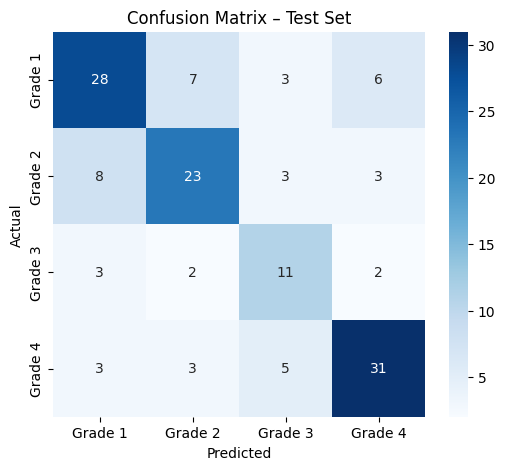

In [11]:
test_preds = best_model.predict(test_data)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_data.classes

print("\n📊 Classification Report (TEST SET)\n")
print(classification_report(
    y_true, y_pred,
    target_names=test_data.class_indices.keys()
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Test Set")
plt.show()


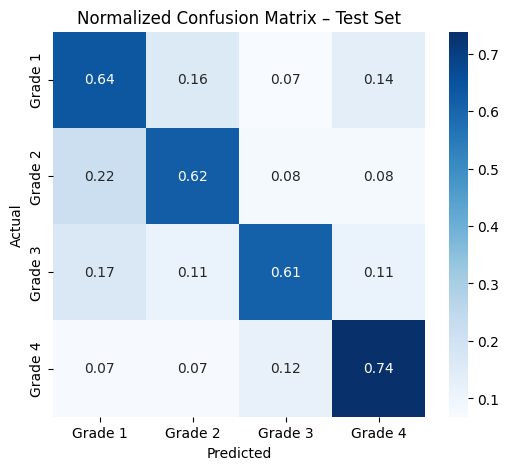

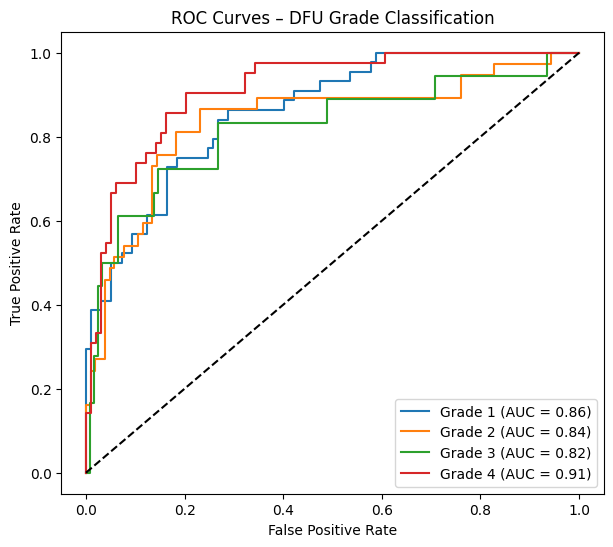

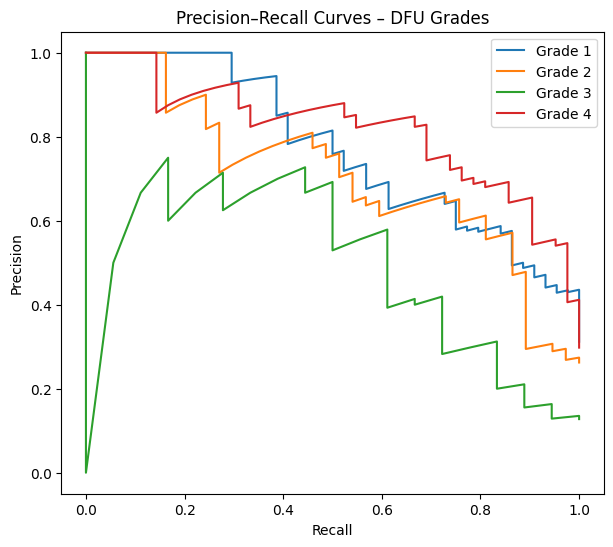

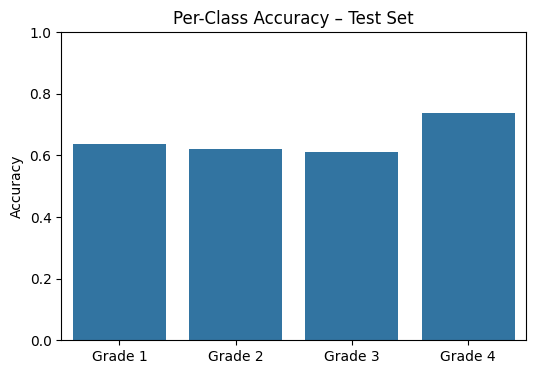

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# ---------------------------------
# 1️⃣ NORMALIZED CONFUSION MATRIX
# ---------------------------------
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=test_data.class_indices.keys(),
    yticklabels=test_data.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix – Test Set")
plt.show()

# ---------------------------------
# 2️⃣ ROC CURVES (ONE-VS-REST)
# ---------------------------------
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

plt.figure(figsize=(7,6))
for i, class_name in enumerate(test_data.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – DFU Grade Classification")
plt.legend()
plt.show()

# ---------------------------------
# 3️⃣ PRECISION–RECALL CURVES
# ---------------------------------
plt.figure(figsize=(7,6))
for i, class_name in enumerate(test_data.class_indices.keys()):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], test_preds[:, i]
    )
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – DFU Grades")
plt.legend()
plt.show()

# ---------------------------------
# 4️⃣ PER-CLASS ACCURACY BAR PLOT
# ---------------------------------
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
sns.barplot(
    x=list(test_data.class_indices.keys()),
    y=class_acc
)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy – Test Set")
plt.show()


In [15]:
# ============================================
# GRAD-CAM FOR DENSENET (DEFINE ONCE)
# ============================================

def grad_cam_densenet(
    model,
    img_array,
    layer_name="conv5_block16_concat"  # DenseNet121 last conv layer
):
    import tensorflow as tf
    import numpy as np

    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()


In [16]:
def detect_orientation(heatmap):
    h, w = heatmap.shape
    scores = {
        "Left": heatmap[:, :w//2].sum(),
        "Right": heatmap[:, w//2:].sum(),
        "Top": heatmap[:h//2, :].sum(),
        "Bottom": heatmap[h//2:, :].sum()
    }
    return max(scores, key=scores.get)


In [17]:
# ============================================
# SINGLE IMAGE INFERENCE + GRAD-CAM
# (CONTINUATION CELL)
# ============================================

def predict_dfu_densenet(image_path):
    # 1️⃣ Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=IMG_SIZE
    )
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0) / 255.0

    # 2️⃣ Predict
    preds = best_model.predict(img_arr, verbose=0)[0]
    grade_idx = np.argmax(preds)
    grade = grade_idx + 1
    confidence = preds[grade_idx] * 100

    # 3️⃣ Grad-CAM
    heatmap = grad_cam_densenet(best_model, img_arr)
    orientation = detect_orientation(heatmap)

    # 4️⃣ Overlay heatmap
    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap_col = cv2.applyColorMap(
        np.uint8(255 * heatmap),
        cv2.COLORMAP_JET
    )
    overlay = heatmap_col * 0.4 + img_arr[0] * 255

    # 5️⃣ Visualization
    plt.figure(figsize=(5,5))
    plt.imshow(overlay.astype("uint8"))
    plt.axis("off")
    plt.title(
        f"Grade {grade} ({confidence:.2f}%) | Spread: {orientation}"
    )
    plt.show()

    # 6️⃣ Console output
    print("🩺 Predicted Grade      :", f"Grade {grade}")
    print("📊 Confidence Score    :", f"{confidence:.2f}%")
    print("📍 Spreading Direction :", orientation)

    print("\n🔍 Grade Probabilities:")
    for i, p in enumerate(preds):
        print(f"  Grade {i+1}: {p*100:.2f}%")


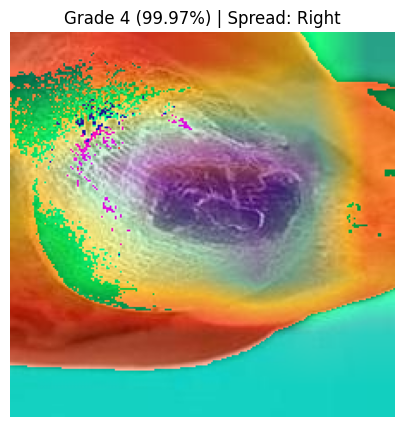

🩺 Predicted Grade      : Grade 4
📊 Confidence Score    : 99.97%
📍 Spreading Direction : Right

🔍 Grade Probabilities:
  Grade 1: 0.01%
  Grade 2: 0.02%
  Grade 3: 0.00%
  Grade 4: 99.97%


In [27]:
predict_dfu_densenet("/content/dfu_data/archive (5)/test/Grade 4/139_jpg.rf.9c67eb6f25f79b21d10b6d228a794935.jpg")

In [ ]:
best_model.save("/content/dfu_densenet_ce_model")


In [23]:
best_model.save("/content/dfu_densenet_ce_model.h5")


In [ ]:
from google.colab import files
files.download("/content/dfu_densenet_ce_model.h5")


In [25]:
best_model.save("/content/dfu_densenet_ce_model.keras")
